In [7]:
# 載入基本套件
import pandas as pd
import numpy as np
import copy
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV , RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

In [2]:
# 設定 data_path
data_path = 'data/'
train = pd.read_csv(data_path + 'training.csv')
test = pd.read_csv(data_path + 'testing.csv')
ids = test['id']
# 讀取檔案
train.head()

,0,1,2,3,4,5,6,7,8,9,...,10448,10449,10450,10451,10452,10453,10454,10455,10456,10457
0,1,1,0,25.013,121.459,17.0,25.013,121.459,17.0,25.013,...,17.0,25.013,121.459,17.0,25.013,121.459,17.0,23.465,120.247,17.0
1,1,1,0,25.013,121.459,17.0,25.013,121.459,17.0,25.013,...,17.0,25.013,121.459,17.0,25.013,121.459,17.0,22.633,120.288,39.0
2,1,1,0,25.013,121.459,17.0,25.013,121.459,17.0,25.013,...,17.0,25.013,121.459,17.0,25.013,121.459,17.0,22.605,120.308,46.0
3,1,1,0,25.013,121.459,17.0,25.013,121.459,17.0,25.013,...,17.0,25.013,121.459,17.0,25.013,121.459,17.0,22.758,120.306,31.0
4,1,1,0,25.013,121.459,17.0,25.013,121.459,17.0,25.013,...,17.0,25.013,121.459,17.0,25.013,121.459,17.0,22.689,120.333,33.0


In [4]:
# 拆分成三個一組
columns=['0','region','height','Longitude','latitude','pm2.5']
train_new = pd.DataFrame(columns=columns)
for i in range(3,len(train.columns),3) :
    df_temp = train.loc[:,['0','1','2',str(i) ,str(i+1) ,str(i+2)]]
    df_temp.columns = columns
    # 過濾重複資料
    df_temp.drop_duplicates(inplace=True)
    train_new = pd.concat([train_new,df_temp], ignore_index=True)
print(f'測試資料前{train_new.shape}')
#測試資料也加入
# for i in range(3,len(test.columns)-3,3) :
#     df_temp = test.loc[:,['1','2',str(i) ,str(i+1) ,str(i+2)]]
#     df_temp.columns = columns
#     # 過濾重複資料
#     df_temp.drop_duplicates(inplace=True)
#     train_new = pd.concat([train_new,df_temp], ignore_index=True)
# print(f'測試資料後{train_new.shape}')

測試資料前(338016, 6)


In [ ]:
# 處理測試資料
test = test.loc[:,['0','1','2','10455' , '10456']]
test.columns = ['0','region','height','Longitude','latitude']
print(test)

      region  height  Longitude  latitude
0          5       0     23.465   120.247
1          5       0     22.633   120.288
2          5       0     22.605   120.308
3          5       0     22.758   120.306
4          5       0     22.689   120.333
...      ...     ...        ...       ...
2659       7      23     24.152   120.641
2660       7      23     25.062   121.527
2661       7      23     24.741   121.089
2662       7      23     23.756   120.677
2663       7      23     22.675   120.293

[2664 rows x 4 columns]


In [13]:
train_new["region"] = pd.to_numeric(train_new["region"])
train_new["height"] = pd.to_numeric(train_new["height"])

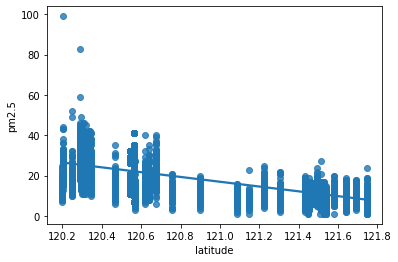

In [14]:
sns.regplot(x = train_new['latitude'], y=train_new['pm2.5'])
plt.show()

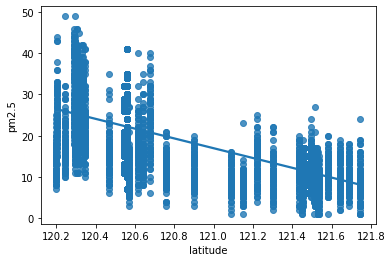

In [15]:
# 調整離群值
keep_indexs = (train_new['pm2.5'] < 50 ) & (train_new['pm2.5'] > 0 )
train_new = train_new[keep_indexs]
sns.regplot(x = train_new['latitude'], y=train_new['pm2.5'])
plt.show()

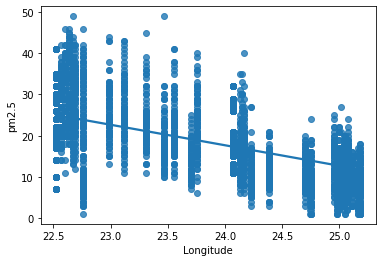

In [16]:
sns.regplot(x = train_new['Longitude'], y=train_new['pm2.5'])
plt.show()

In [17]:
# 切分訓練集/測試集
target = train_new['pm2.5']
train_split = train_new.drop(['pm2.5'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(train_split, target, test_size=0.25, random_state=4)

print(x_train)

        0  region  height  Longitude  latitude
283743  1       3      15     24.066   120.542
328925  1       2       5     25.069   121.481
2598    1       1       6     25.013   121.459
61153   1       1       1     25.013   121.459
15724   1       4       4     22.523   120.561
...    ..     ...     ...        ...       ...
107578  1       3      10     24.066   120.542
94601   1       2      17     25.069   121.481
115144  1       2      16     25.069   121.481
129384  1       4       0     22.523   120.561
120705  1       2       9     25.069   121.481

[253509 rows x 5 columns]


In [18]:
rf = RandomForestRegressor(n_estimators=300, min_samples_split=9, min_samples_leaf=10, 
                           max_features='sqrt', max_depth=8, bootstrap=False)
gdbt = GradientBoostingRegressor(tol=0.1, subsample=0.37, n_estimators=200, max_features=20, 
        max_depth=6, learning_rate=0.03)

In [19]:
cv_params = {"tol" : np.linspace(0.01,0.5,10),"subsample":np.linspace(0.01,0.5,10) , "n_estimators": range(200,800,50) , "max_features" : range(10,20,1) , "max_depth" : range(1,10,1),"learning_rate" : np.linspace(0.01,2,20)}
other_params = {"tol": "0.1", "subsample": "0.37", "n_estimators": "200", "max_features": "20", "max_depth": "6", "learning_rate": "0.03"}
gdbt = GradientBoostingRegressor(**other_params)
optimized_GBM = RandomizedSearchCV(estimator=gdbt, param_distributions = cv_params, scoring='neg_log_loss', n_iter=300, cv=5, n_jobs=4)
optimized_GBM.fit(x_train, y_train)
evalute_result = optimized_GBM.cv_results_
print('每輪结果:{0}'.format(evalute_result))
print('参数的最佳取值：{0}'.format(optimized_GBM.best_params_))
print('最佳模型得分:{0}'.format(optimized_GBM.best_score_))

In [ ]:
# 梯度提升機預測檔 
gdbt.fit(x_train, y_train)
gdbt_pred = gdbt.predict(x_test)
# sub = pd.DataFrame({'id': ids, 'pm2.5': np.round(gdbt_pred)})
# sub.to_csv('728rf.csv', index=False)

In [ ]:
# 隨機森林預測檔
rf.fit(x_train, y_train)
rf_pred = rf.predict(x_test)
# sub = pd.DataFrame({'id': ids, 'pm2.5': np.round(rf_pred)})
# sub.to_csv('728rf.csv', index=False)

ValueError: array length 147215 does not match index length 2664

In [ ]:
print(mean_squared_error(y_test, rf_pred))

1.9671349740897566


In [ ]:
print(rf_pred)

[12.55126036 22.88516391 12.55126036 ... 16.70529079  9.54111678
 23.80989597]


In [ ]:
# from ctypes.wintypes import tagRECT
# import xgboost as xgb

# # 建立 XGBRegressor 模型
# cv_params = {'max_depth': [3, 4, 5, 6, 7, 8, 9, 10], 'min_child_weight': [1, 2, 3, 4, 5, 6]}
# other_params = {'learning_rate': 0.07, 'n_estimators': 650, 'max_depth': 7, 'min_child_weight': 6, 'seed': 0,
#                     'subsample': 0.6, 'colsample_bytree': 0.8, 'gamma': 0.1, 'reg_alpha': 3, 'reg_lambda': 1}
# xgbrModel = xgb.XGBRegressor(**other_params)
# # 使用訓練資料訓練模型
# xgbrModel.fit(train_split, target)
# # 使用test資料預測
# predicted=xgbrModel.predict(test)
# sub = pd.DataFrame({'id': ids, 'pm2.5': np.round(predicted)})
# sub.to_csv('727.csv', index=False) 

# optimized_GBM = GridSearchCV(estimator=xgbrModel, param_grid=cv_params, scoring='r2', cv=5, verbose=1, n_jobs=4)
# optimized_GBM.fit(x_train, y_train)
# evalute_result = optimized_GBM.cv_results_
# print('每輪结果:{0}'.format(evalute_result))
# print('参数的最佳取值：{0}'.format(optimized_GBM.best_params_))
# print('最佳模型得分:{0}'.format(optimized_GBM.best_score_))